In [0]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%matplotlib inline

In [0]:
from pathlib import Path

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt

In [0]:
# split = (80, 10, 10)
# splits = tfds.Split.TRAIN.subsplit(weighted=split)
splits = ("train[:80]", "train[:10]", "train[:10]")
(cat_train, cat_valid, cat_test), info = tfds.load(
    'cats_vs_dogs',
    split=splits,
    with_info=True,
    as_supervised=True
)

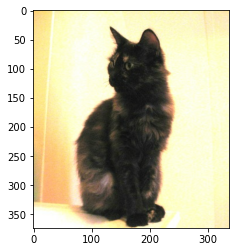

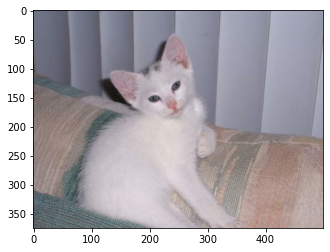

In [0]:
for image, label in cat_train.take(2):
    plt.figure()
    plt.imshow(image)

In [0]:
IMAGE_SIZE = 100
def pre_process_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image, label

In [0]:
TRAIN_BATCH_SIZE = 64
cat_train = (
    cat_train.map(pre_process_image)
    .shuffle(1000)
    .repeat()
    .batch(TRAIN_BATCH_SIZE)
)
cat_valid = (
    cat_valid.map(pre_process_image)
    .repeat()
    .batch(1000)
)

In [0]:
head = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
])

In [0]:
avg_pool = tf.keras.Sequential([
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [0]:
std_model = tf.keras.Sequential([
    head,
    avg_pool
])

In [0]:
std_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"]
)

In [0]:
log_dir = Path(".").resolve()/"logs/standard_model"
log_dir.mkdir(exist_ok=True, parents=True)

In [0]:
callbacks = [
    tf.keras.callbacks.TensorBoard(
        log_dir=str(log_dir),
        update_freq='batch')
]

In [0]:
std_model.fit(
    cat_train,
    epochs=7,
    steps_per_epoch=23262//TRAIN_BATCH_SIZE,
    validation_data=cat_valid,
    validation_steps=10,
    callbacks=callbacks
)

Train for 363 steps, validate for 10 steps
Epoch 1/7
363/363 [==============================] - 305s 840ms/step - loss: 0.0223 - accuracy: 0.9946 - val_loss: 0.3510 - val_accuracy: 0.8000
Epoch 2/7
 59/363 [===>..........................] - ETA: 4:26 - loss: 5.4254e-04 - accuracy: 1.0000